## Libraries

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as torchdata
import torchvision

from PIL import Image
from pathlib import Path

from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm

## Utils

In [2]:
def set_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(1213)

## Data

### MNIST

In [4]:
mnist = torchvision.datasets.MNIST(root="./data",
                                   train=True,
                                   download=True)

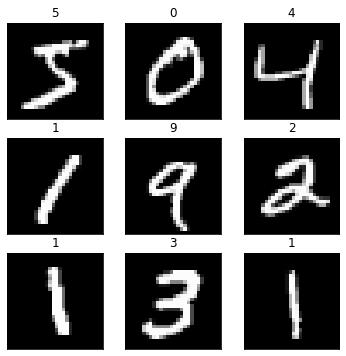

In [5]:
images = mnist.data
labels = mnist.targets

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        image = images[i * 3 + j].numpy()
        axes[i, j].imshow(image, cmap="gray")
        axes[i, j].tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
        axes[i, j].set_title(f"{labels[i * 3 + j]}")

### PascalVOC 2007

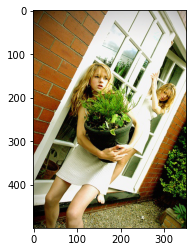

In [6]:
image_dir = Path("./data/VOCdevkit/VOC2007/JPEGImages/")
images = list(image_dir.glob("*.jpg"))
image = Image.open(images[0])
plt.imshow(image);

### Add MNIST into VOC image

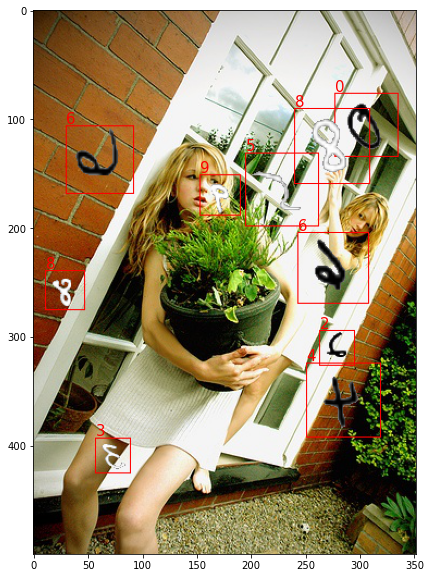

In [7]:
base_image = np.array(Image.open(images[0]))
mnist_images = mnist.data

height, width, _ = base_image.shape
bboxes = []
labels = []
for _ in range(10):
    # choose MNIST size
    size = np.random.randint(20, 70)
    ypos = np.random.randint(0, height - size)
    xpos = np.random.randint(0, width - size)
    
    idx = np.random.randint(0, len(mnist_images))
    mnist_image = cv2.resize(mnist_images[idx].numpy(), (size, size))[:, ::-1]
    mnist_image = np.stack([
        mnist_image,
        mnist_image,
        mnist_image], axis=2)
    mask = mnist_image > 127
    # write in white color
    if np.random.rand() > 0.5:
        base_image[ypos:ypos+size, xpos:xpos+size][mask] = mnist_image[mask]
    else:
        base_image[ypos:ypos+size, xpos:xpos+size][mask] = (255 - mnist_image[mask])
        
    bboxes.append([xpos, ypos, xpos+size, ypos+size])
    labels.append(int(mnist.targets[idx]))
    
    cv2.rectangle(base_image, (xpos, ypos), (xpos+size, ypos+size), (255, 0, 0))
    
plt.figure(figsize=(8, 10))
plt.imshow(base_image)
for label, bbox in zip(labels, bboxes):
    plt.annotate(str(label), xy=(bbox[0], bbox[1]-2), color="red", fontsize=15)

### PyTorch Dataset

In [8]:
class VOCMNISTDataset(torchdata.Dataset):
    def __init__(self, images: list, mnist_images, mnist_targets, n_embed=10):
        self.images= images
        self.mnist_images = mnist_images
        self.mnist_targets = mnist_targets
        self.n_embed = n_embed
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index: int):
        transform = transforms.Compose([transforms.ToTensor()])
        
        base_image_path = self.images[index]
        base_image = np.array(Image.open(base_image_path))
        
        image_id = base_image_path.name
        
        height, width, _ = base_image.shape
        bboxes = []
        labels = []
        
        for _ in range(self.n_embed):
            # choose MNIST size
            size = np.random.randint(20, 70)
            ypos = np.random.randint(0, height - size)
            xpos = np.random.randint(0, width - size)
    
            idx = np.random.randint(0, len(self.mnist_images))
            mnist_image = cv2.resize(
                self.mnist_images[idx].numpy(), (size, size))[:, ::-1]
            mnist_image = np.stack([
                mnist_image,
                mnist_image,
                mnist_image], axis=2)
            mask = mnist_image > 127

            if np.random.rand() > 0.5:
                # write in white color
                base_image[ypos:ypos+size, xpos:xpos+size][mask] = mnist_image[mask]
            else:
                # black color
                base_image[ypos:ypos+size, xpos:xpos+size][mask] = (255 - mnist_image[mask])

            bboxes.append([xpos, ypos, xpos+size, ypos+size])
            labels.append(int(mnist.targets[idx]))
        bboxes = np.array(bboxes)
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            
        image = transform(Image.fromarray(base_image))
        target = {}
        target["boxes"] = torch.from_numpy(bboxes).float()
        target["area"] = torch.from_numpy(area).float()
        target["labels"] = torch.tensor(labels).long()
        target["iscrowd"] = torch.zeros((self.n_embed,)).long()
        target["image_id"] = torch.tensor([index])
        
        return image, target, image_id

In [9]:
train_images, test_images = train_test_split(images, test_size=0.3)
train_mnist_images, test_mnist_images, train_mnist_targets, test_mnist_targets = train_test_split(
    mnist.data, mnist.targets)

train_dataset = VOCMNISTDataset(train_images, train_mnist_images, train_mnist_targets)
test_dataset = VOCMNISTDataset(test_images, test_mnist_images, test_mnist_targets)

In [10]:
train_dataset[0]

(tensor([[[0.7216, 0.6157, 0.5922,  ..., 0.9176, 0.9294, 0.9176],
          [0.7922, 0.5961, 0.6353,  ..., 0.9137, 0.9255, 0.9137],
          [0.7176, 0.6235, 0.7608,  ..., 0.9216, 0.9294, 0.9176],
          ...,
          [0.2902, 0.2980, 0.2824,  ..., 0.2863, 0.2824, 0.2706],
          [0.3137, 0.3020, 0.2745,  ..., 0.2941, 0.2902, 0.2824],
          [0.2784, 0.2706, 0.2627,  ..., 0.2863, 0.2824, 0.2863]],
 
         [[0.7490, 0.6549, 0.6314,  ..., 0.9686, 0.9804, 0.9686],
          [0.8314, 0.6353, 0.6784,  ..., 0.9647, 0.9765, 0.9647],
          [0.7608, 0.6667, 0.8039,  ..., 0.9725, 0.9804, 0.9686],
          ...,
          [0.2588, 0.2627, 0.2588,  ..., 0.2706, 0.2667, 0.2549],
          [0.2863, 0.2667, 0.2510,  ..., 0.2784, 0.2745, 0.2667],
          [0.2510, 0.2392, 0.2392,  ..., 0.2706, 0.2667, 0.2706]],
 
         [[0.8510, 0.7529, 0.7294,  ..., 0.9922, 1.0000, 0.9922],
          [0.9294, 0.7333, 0.7647,  ..., 0.9882, 1.0000, 0.9882],
          [0.8471, 0.7529, 0.8902,  ...,

## Training Setup

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torchdata.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = torchdata.DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# mnist + background
num_classes = 10
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device);
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [13]:
EPOCHS = 10
model.train()
tqdm_bar = tqdm(range(EPOCHS))
for epoch in tqdm_bar:
    for i, batch in enumerate(train_loader):
        images, targets, image_ids = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tqdm_bar.set_description(f"Epoch [{epoch+1}/{EPOCHS}] "
                                 f"Step [{i+1}/{len(train_loader)}] "
                                 f"loss: {loss_value:.3f}")

In [14]:
output_dir = Path("./out")
output_dir.mkdir(exist_ok=True, parents=True)

torch.save(model.state_dict(), output_dir / "model.pth")

## Inference

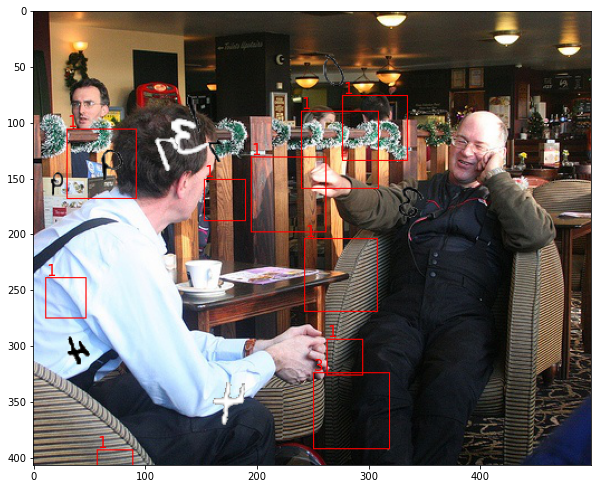

In [55]:
model.eval()
images, _, _ = next(iter(test_loader))

images = list(img.to(device) for img in images)

with torch.no_grad():
    outputs = model(images)

image = images[0].permute(1, 2, 0).cpu().numpy()
image = (image * 255).astype(np.uint8).copy()

boxes = outputs[0]["boxes"].detach().cpu().numpy()
scores = outputs[0]["scores"].detach().cpu().numpy()
labels = outputs[0]["labels"].detach().cpu().numpy()

boxes = boxes[scores >= 0.5].astype(np.int32)
scores = scores[scores >= 0.5]

plt.figure(figsize=(10, 10))
for _, bbox in zip(labels, bboxes):
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0))
    
for label, bbox in zip(labels, bboxes):
    plt.annotate(str(label), xy=(bbox[0], bbox[1]-2), color="red", fontsize=15)
plt.imshow(image)
plt.show()

In [58]:
boxes = outputs[0]["boxes"].detach().cpu().numpy()
scores = outputs[0]["scores"].detach().cpu().numpy()
labels = outputs[0]["labels"].detach().cpu().numpy()

In [61]:
labels

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 7,
       2, 2, 7, 2, 7, 7, 2, 7, 2, 2, 7, 7, 7, 2, 2, 7, 8, 8, 7, 2, 9, 9,
       9, 9, 8, 8, 8, 6, 8, 9, 9, 8, 6, 9, 9, 8, 6, 6, 6, 9, 6, 6, 6, 8,
       9, 6, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])